In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

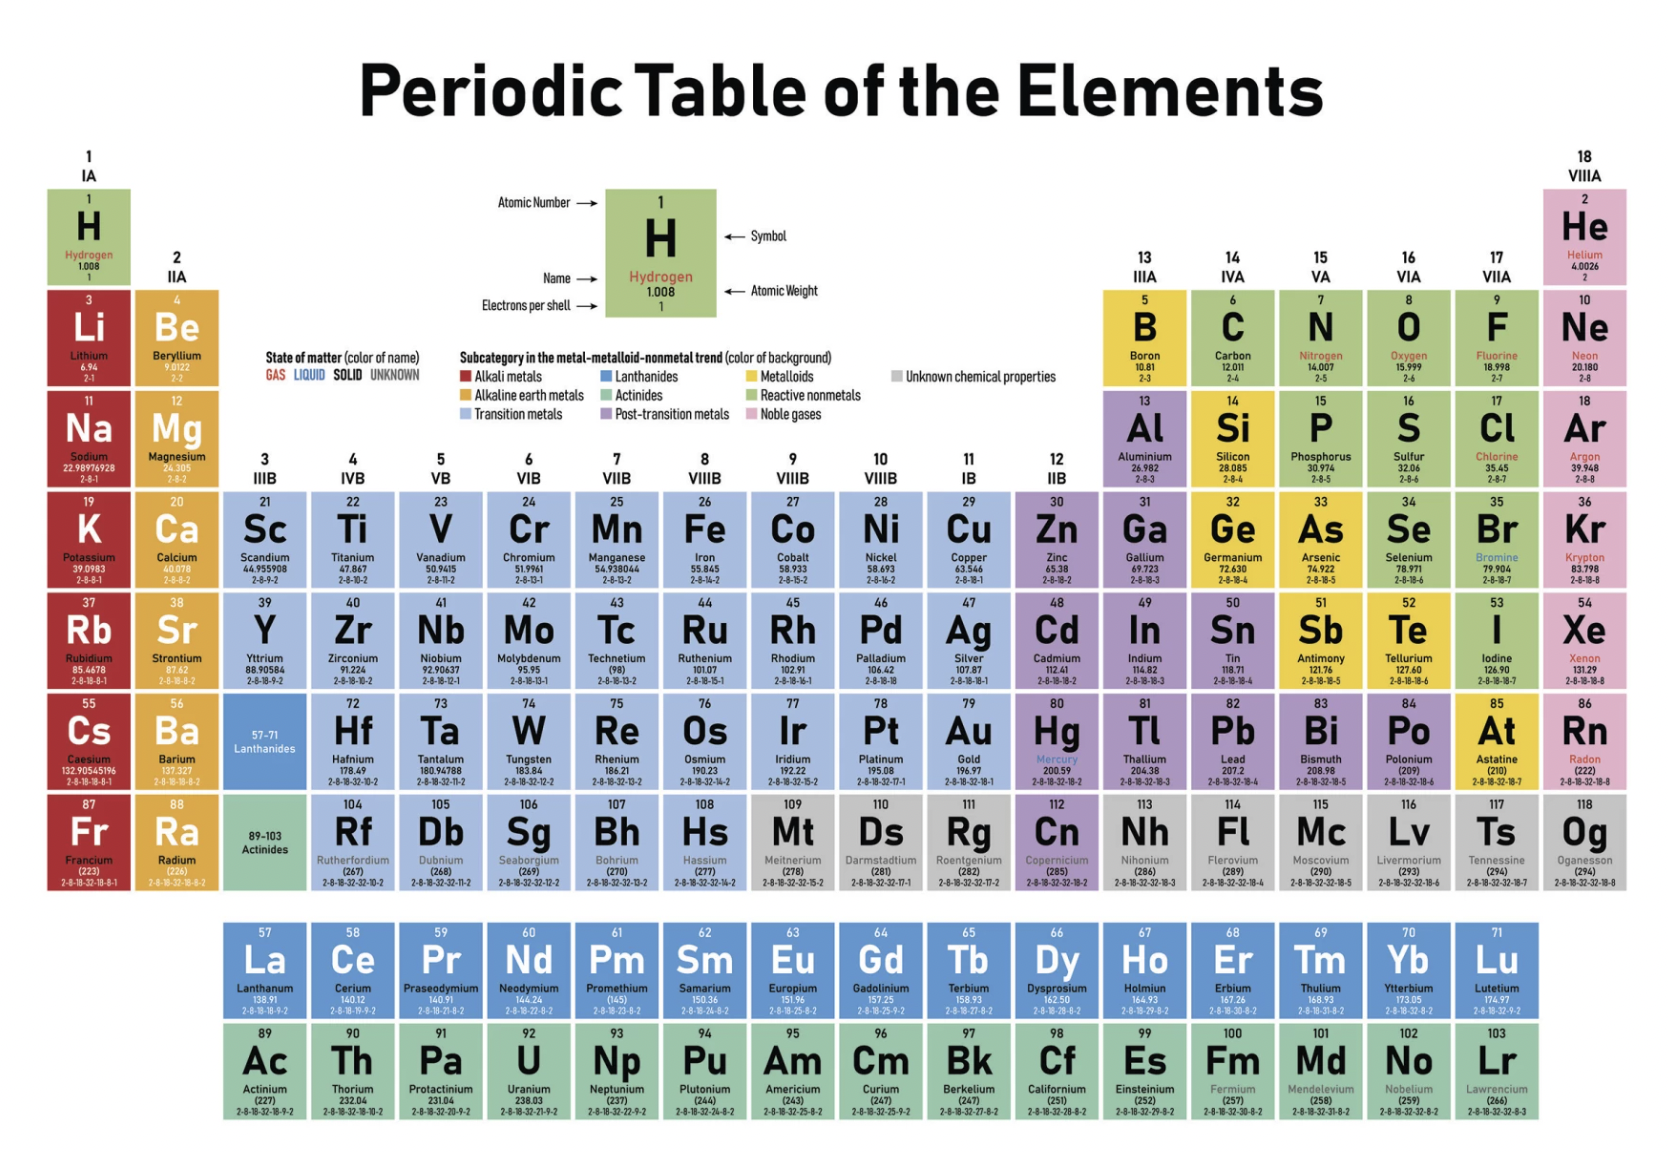

In [ ]:
data = pd.read_csv('../input/periodic/periodic_table.csv')
data2 = data.copy()
data

In [ ]:
data.drop(['Discoverer','Year','Element','Symbol'],axis = 1,inplace=True) # we can use atomic number to actually identify the Element.

In [ ]:
data.info()

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data)
profile.to_notebook_iframe()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le_RA = LabelEncoder()
le_N = LabelEncoder()
le_M = LabelEncoder()
le_NM = LabelEncoder()
le_MM = LabelEncoder()
le_TY = LabelEncoder()
le_PH = LabelEncoder()

In [ ]:
data['Radioactive'] = le_RA.fit_transform(data['Radioactive'])
data['Natural'] = le_N.fit_transform(data['Natural'])
data['Metal'] = le_M.fit_transform(data['Metal'])
data['Nonmetal'] = le_NM.fit_transform(data['Nonmetal'])
data['Metalloid'] = le_MM.fit_transform(data['Metalloid'])
data['Type'] = le_TY.fit_transform(data['Type'])
data['Phase'] = le_PH.fit_transform(data['Phase'])

In [ ]:
data.info()

In [ ]:
data.isna().sum()

In [ ]:
pip install sweetviz

In [ ]:
import sweetviz as sv
report = sv.analyze(data)
report.show_notebook()

In [ ]:
data.interpolate(method ='linear', limit_direction ='forward',inplace=True)
# I have use linear method to fill the missing values as 
# I have observed in the profile report that mostly the properties are linearly dependent.

In [ ]:
data.isna().sum()

# Data after Cleaning 

In [ ]:
import sweetviz as sv
report = sv.analyze(data)
report.show_notebook()

# Now, we will try to predict the Density of element based upon different parameters.

In [ ]:
X = data.drop('Density',axis=1)
y = data['Density']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor() # Define classifier
knn.fit(X_train, y_train) # Train model
knn.score(X_test,y_test)

In [ ]:
y_pred = knn.predict(X_test)
plt.scatter(y_test,y_pred)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor() # Define classifier
dt.fit(X_train, y_train) # Train model
dt.score(X_test,y_test)

In [ ]:
y_pred = dt.predict(X_test)
plt.scatter(y_test,y_pred)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor() # Define classifier
rf.fit(X_train, y_train) # Train model
rf.score(X_test,y_test)

In [ ]:
y_pred = rf.predict(X_test)
plt.scatter(y_test,y_pred)
plt.show()

In [ ]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor()
mlp.fit(X_train, y_train)
mlp.score(X_test,y_test)

In [ ]:
y_pred = mlp.predict(X_test)
plt.scatter(y_test,y_pred)
plt.show()

In [ ]:
# Define estimators
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LogisticRegression

estimator_list = [
    ('knn',knn),
    ('dt',dt),
    ('rf',rf),
    ('mlp',mlp) ]

# Build stack model
stack_model = StackingRegressor(
    estimators=estimator_list, final_estimator=RandomForestRegressor())

# Train stacked model
stack_model.fit(X_train, y_train)
stack_model.score(X_test,y_test)

In [ ]:
import matplotlib.pyplot as plt
y_pred = stack_model.predict(X_test)
plt.scatter(y_test,y_pred)
plt.show()

In [ ]:
data3 = data2[['AtomicNumber','Density']]
y_pred = rf.predict(X)
data3['Prediction'] = y_pred
data3.head(3)

In [ ]:
plt.figure(figsize=(20,15))
plt.plot(data3['AtomicNumber'],data3['Density'],label='Actual')
plt.plot(data3['AtomicNumber'],data3['Prediction'],label='Predicted',color='r')
plt.title("Density of Element")
plt.xlabel("AtomicNumber")
plt.ylabel("AtomicMass")
plt.legend()
plt.show()

# Let's make use of AutoML to get best model for our dataset

In [ ]:
pip install git+https://github.com/pycaret/pycaret.git

In [ ]:
from pycaret.regression import setup, compare_models, predict_model
pycaret_automl = setup(data=data, target = 'Density', session_id=667)

In [ ]:
pycaret_models = compare_models(sort='MSE', budget_time=5)

In [ ]:
print(pycaret_models)

In [ ]:
from tpot import TPOTRegressor

tpot_automl = TPOTRegressor(generations=10, population_size=10, 
                            verbosity=2, scoring='neg_mean_squared_error',   
                            max_time_mins=5, random_state = 667)

In [ ]:
tpot_automl.fit(X_train, y_train)

In [ ]:
tpot_automl.score(X_test, y_test)

--------
------

# now let's apply the models we are suggested by AutoML

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(alpha=0.95, learning_rate=0.5, max_depth=9, max_features=0.25, min_samples_leaf=2, min_samples_split=4, n_estimators=100, subsample=0.8)
best_model = GBR.fit(X_train,y_train)

In [ ]:
GBR.score(X_train,y_train)

In [ ]:
data4 = data2[['AtomicNumber','Density']]
y_pred = GBR.predict(X)
data4['Prediction'] = y_pred
data4.head(3)

In [ ]:
# Much better as compared to any other model. 
plt.figure(figsize=(20,15))
plt.plot(data4['AtomicNumber'],data4['Density'],label='Actual')
plt.plot(data4['AtomicNumber'],data4['Prediction'],label='Predicted',color='r')
plt.title("Density of Element")
plt.xlabel("AtomicNumber")
plt.ylabel("Density")
plt.legend()
plt.show()